## Creates binarized Seurat objects, integrates conditions and annotates genes by nearby peaks

In [1]:
# Input info
cellr_in = "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist/" 
outdir =  "/data2/mito_lineage/output/annotation/data/CHIP_april08_2021/MTblacklist/mergedSamples" 
sample_names = "Control,Flt3l,Input"
samples = "Control,Flt3l,Input"

lsi_start_comp = 2

# Parameters
nTop = 25000
cores = 24

In [2]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

In [3]:
# # Input info
# cellr_in <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist"
# samples <- "J2,P2"
# sample_names <- "Flt3l,Control"

# # Saving
# outdir <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/mergedSamples" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# # Parameters
# nTop = 25000
# assay="RNA"

# cores = 36

In [4]:
samples <- unlist(strsplit(samples, ",")[[1]])
sample_names <- unlist(strsplit(sample_names, ","))

samples

[1] "Control" "Flt3l"   "Input"

In [5]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)

plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

## Merge all peaks

In [6]:
read.peaks <- function(exp, cellr_in){
    print('here')
    print(file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"))
    peaks <- read.table(
      file = file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"),
      col.names = c("chr", "start", "end")
    )
    # convert to genomic ranges
    gr <- makeGRangesFromDataFrame(peaks)
    return(gr)
}


gr.full <- c(sapply(samples, read.peaks, cellr_in=cellr_in, USE.NAMES=F))

gr.full.c <- gr.full[[1]]
if (length(gr.full)>1){
    for (i in 2:length(gr.full)){
      gr.full.c <- c(gr.full.c, gr.full[[i]])
    }
}
combined.peaks <- reduce(x = c(gr.full.c))

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist//Control/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist//Flt3l/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist//Input/outs/filtered_peak_bc_matrix/peaks.bed"


GRanges object with 263336 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1        9872-10620      *
       [2]     chr1       96454-96767      *
       [3]     chr1     180638-181142      *
       [4]     chr1     191518-191976      *
       [5]     chr1     267762-268278      *
       ...      ...               ...    ...
  [263332]     chrY 56872076-56872403      *
  [263333]     chrY 56873720-56873847      *
  [263334]     chrY 56873946-56874635      *
  [263335]     chrY 56879619-56879842      *
  [263336]     chrY 56880257-56880611      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Create fragment objects

In [7]:
# create_frag <- function(exp, cellr_in){
#     barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
#     barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
#     frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
#     # quantify multiome peaks in the scATAC-seq dataset
#     frags.curr <- CreateFragmentObject(path = frag_file,cells= barcodes[["X1"]])
#     barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=exp)
#     ## Quantify peaks
#     curr.counts <- FeatureMatrix(
#       fragments = frags.curr,
#       features = combined.peaks,
#       cells = rownames(barcodes),
#       process_n = 8
#     )
    
#     ## Create the objects
#     curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr)
#     curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=exp, meta.data=barcodes)
#     curr <- BinarizeCounts(curr)
#     return(curr)
# }
allSE = c() 

samples_df <- cbind(sample_names, samples)
print('samples_df')
print(samples_df)
for (row in 1:nrow(samples_df)){
    exp <- (samples_df[[row, "samples"]])
    name <- (samples_df[[row, "sample_names"]]) 
    
#for (exp in samples) {
    print('exp')
    print(exp)
    print('name')
    print(name)
    barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
    barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
    barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=name)
    frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
    
    cells.meta.f <- file.path(cellr_in, exp, "outs", "singlecell.csv") 
    cells.meta <- as.data.frame(readr::read_csv(cells.meta.f)) %>% tibble::column_to_rownames(var="barcode") %>% tibble::add_column(proj=name)
    cells.meta <- cells.meta[rownames(cells.meta) %in% rownames(barcodes), ]

    # quantify multiome peaks in the scATAC-seq dataset
    
    
    print("Creating fragments object")
    frags.curr <- CreateFragmentObject(path = frag_file, cells= rownames(barcodes))
    #print(frags.curr)
    print("Quantifying peaks")
    ## Quantify peaks
    curr.counts <- FeatureMatrix(
      fragments = frags.curr,
      features = combined.peaks,
      cells = rownames(barcodes),
      process_n = cores
    )
    
    print("Creating chromatin assay")
    ## Create the objects and use simple filters
    curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr, min.cells = 10, min.features = 200)
    curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=name, meta.data=cells.meta)
    print('curr_assay')
    print(head(curr_assay))
    print('curr')
    print(head(curr[[]]))
    allSE = c(allSE, curr)
    #return(curr)
}

allSE

#allSE <- sapply(samples, create_frag, cellr_in=cellr_in)

[1] "samples_df"
     sample_names samples  
[1,] "Control"    "Control"
[2,] "Flt3l"      "Flt3l"  
[3,] "Input"      "Input"  
[1] "exp"
[1] "Control"
[1] "name"
[1] "Control"


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom
Rows: 843 Columns: 1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 470007 Columns: 18

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Creating fragments object"


Computing hash



[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = name, :
"Some cells in meta.data not present in provided counts matrix."


[1] "curr_assay"
data frame with 0 columns and 10 rows
[1] "curr"
                   orig.ident nCount_ATAC nFeature_ATAC  total duplicate
AAACGAATCTTACTCA-1    Control         215           215    779        47
AAACTCGAGTGGTGTG-1    Control         390           387  16911      5224
AAACTCGTCAATGCAC-1    Control        1030          1012  11963      2864
AAACTGCTCTCGCGGA-1    Control       21843         15140 265035     83694
AAAGATGAGCGCATTT-1    Control         373           368  15367      5530
AAAGATGCAGCAACGA-1    Control       15235         10565 250347     85267
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAATCTTACTCA-1        6        7      37           299            383
AAACTCGAGTGGTGTG-1       95      356     690          9717            829
AAACTCGTCAATGCAC-1       63       78     583          6889           1486
AAACTGCTCTCGCGGA-1     1575     1101    9756        141471          27438
AAAGATGAGCGCATTT-1       83      294     733         

Rows: 5313 Columns: 1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 532237 Columns: 18

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Creating fragments object"


Computing hash



[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = name, :
"Some cells in meta.data not present in provided counts matrix."


[1] "curr_assay"
data frame with 0 columns and 10 rows
[1] "curr"
                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACGAAAGGAAACTT-1      Flt3l        3108          2935 49701      5002
AAACGAAGTCCAAGAG-1      Flt3l        5131          4737 62869      9096
AAACGAAGTCCGAGCT-1      Flt3l        8403          7462 60574     11583
AAACGAAGTTCAGAAA-1      Flt3l        3095          2948 32202      4591
AAACGAAGTTTGAAGA-1      Flt3l        7979          7225 68829     12010
AAACGAATCAGCCGGT-1      Flt3l        1251          1223 13222      1216
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAAAGGAAACTT-1      164       92    1138         37812           5493
AAACGAAGTCCAAGAG-1      249      139    1902         42086           9397
AAACGAAGTCCGAGCT-1      352      141    2087         31767          14644
AAACGAAGTTCAGAAA-1      146       90     911         19849           6615
AAACGAAGTTTGAAGA-1      432      163    2209         39985  

Rows: 222 Columns: 1

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 361348 Columns: 18

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Creating fragments object"


Computing hash



[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"
[1] "curr_assay"
data frame with 0 columns and 10 rows
[1] "curr"
                   orig.ident nCount_ATAC nFeature_ATAC   total duplicate
AAACGAATCTTACTCA-1      Input       20967         14540 1136869    627713
AAAGGATAGTCGTGAG-1      Input       34012         21373 1065254    711897
AAATGAGGTCAATACC-1      Input       23267         17558  408417    114699
AAATGCCAGGAACCGT-1      Input        6184          5352  312883     92752
AAATGCCCACCGAAAG-1      Input       33799         22561  582430    187426
AACAAAGCAATTCAGC-1      Input       16096         12306  922273    390846
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAATCTTACTCA-1     5110     3785   53071        404558          42632
AAAGGATAGTCGTGAG-1     5461     3619   57926        218077          68274
AAATGAGGTCAATACC-1     1725     1858   17193        216353          56589
AAATGCCAGGAACCGT-1     1351     1566   11187        190764          15263
AAATGCCCACCGAAA

[[1]]
An object of class Seurat 
100522 features across 743 samples within 1 assay 
Active assay: ATAC (100522 features, 0 variable features)

[[2]]
An object of class Seurat 
187490 features across 5312 samples within 1 assay 
Active assay: ATAC (187490 features, 0 variable features)

[[3]]
An object of class Seurat 
80277 features across 222 samples within 1 assay 
Active assay: ATAC (80277 features, 0 variable features)


In [8]:
samples_df

sample_names,samples
Control,Control
Flt3l,Flt3l
Input,Input


## Merge

In [9]:
# # merge all datasets, adding a cell ID to make sure cell names are unique
# combined <- merge(
#   x = allSE[[1]],
#   #y = allSE[[3]],
#   y = unlist(allSE[2:length(allSE)], use.names=F),
#   add.cell.ids = sample_names
# )
# combined[["ATAC"]]



In [10]:
# Add sample names to cell prefix here.
for (i in 1:length(allSE)){
    print(i)
    curr.SE <- allSE[[i]]
    allSE[[i]] <- RenameCells(allSE[[i]], 
                    paste(curr.SE$orig.ident,colnames(curr.SE), sep="_")
                    )
}

combined <-  merge(
  x = allSE[[1]],
  #y = allSE[[3]],
  y = allSE[[2]]
  #add.cell.ids = sample_names[1:2]
  )


if (length(sample_names) > 2) {
    for (i in 3:length(sample_names)){
        combined <- merge(x=combined,
                             y = allSE[[i]])
        }
}

[1] 1
[1] 2
[1] 3


In [11]:
# # merge all datasets, adding a cell ID to make sure cell names are unique
# combined <- merge(
#   x = allSE[[1]],
#   y = unlist(allSE[2:length(allSE)], use.names=FALSE), 
#   add.cell.ids = sample_names,
#   merge.data=FALSE
# )
# combined[["ATAC"]]



In [12]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
189527 features across 6277 samples within 1 assay 
Active assay: ATAC (189527 features, 158057 variable features)

### Plot metadata passed_filters, nCount_ATAC, and duplicates

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



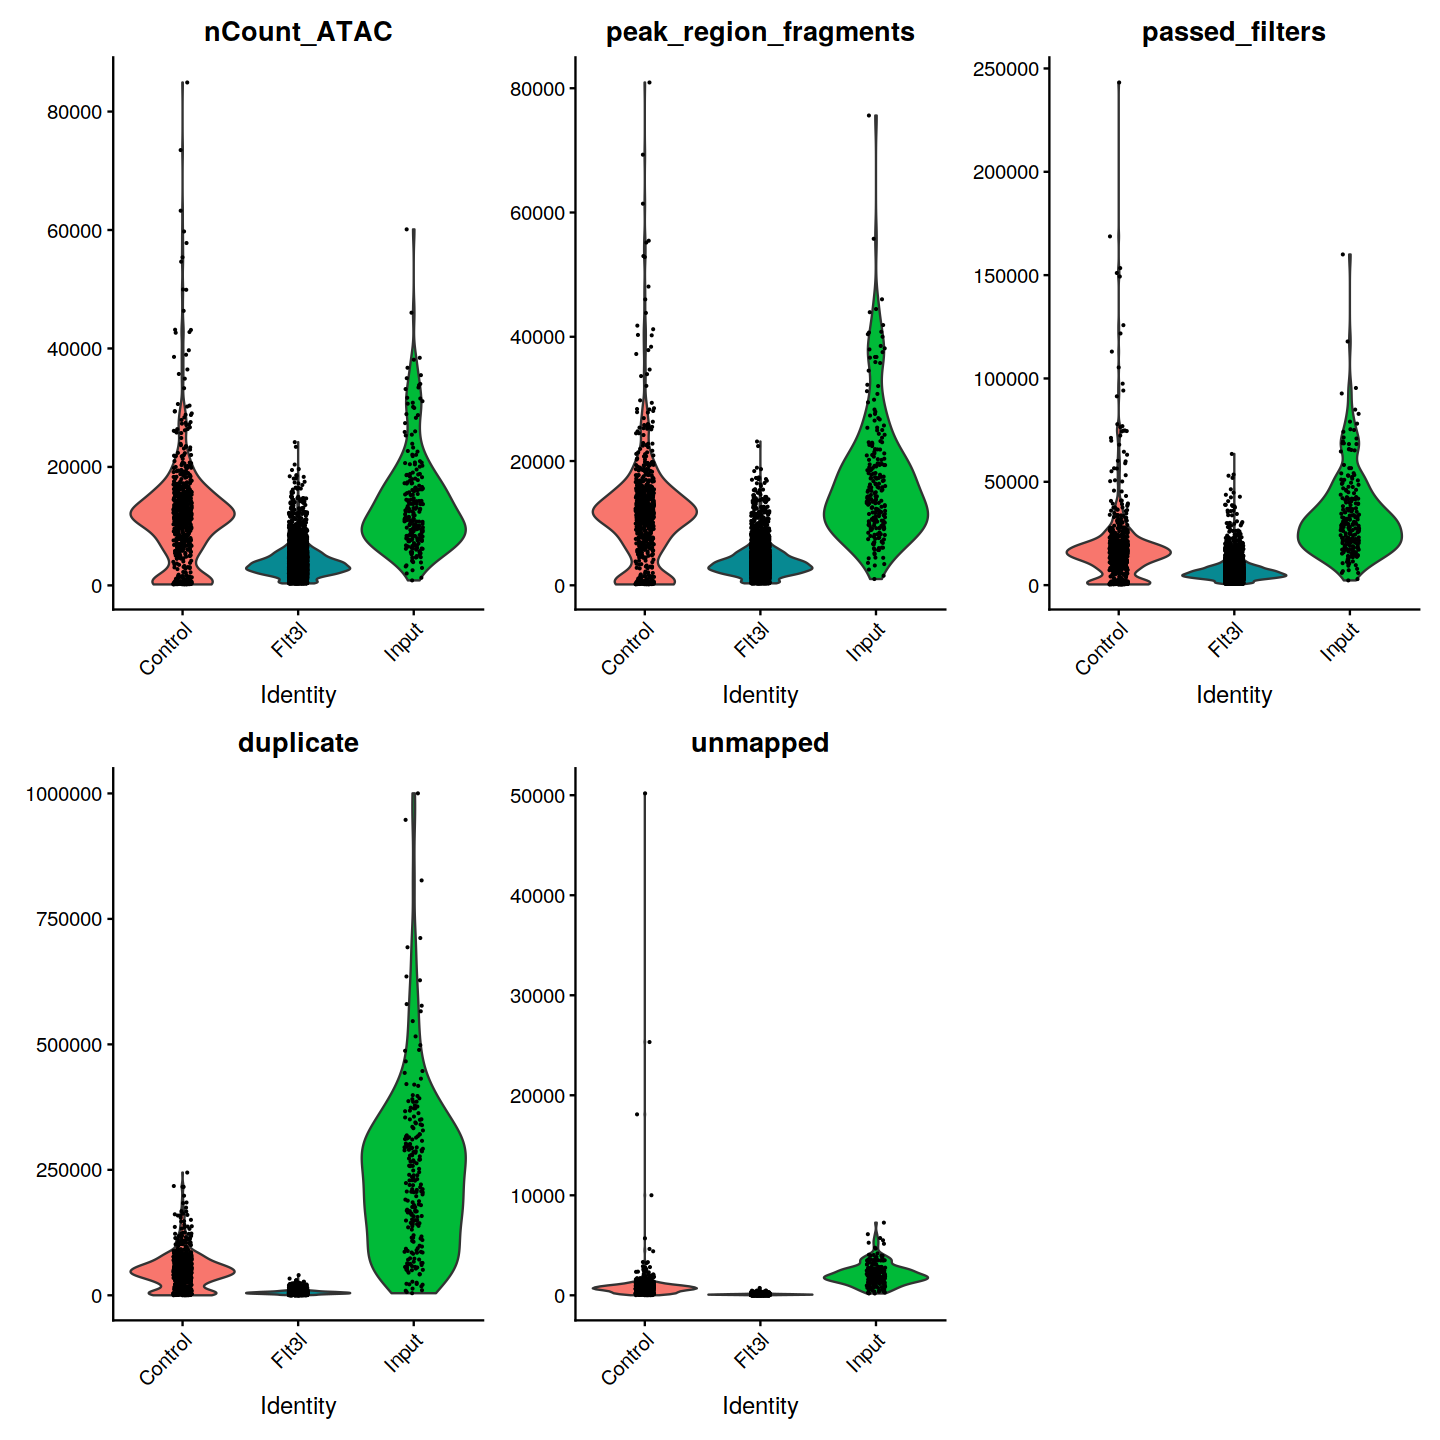

In [13]:
combined$orig.ident <- factor(combined$orig.ident, levels = sample_names)

VlnPlot(
  object = combined,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
02:49:30 UMAP embedding parameters a = 0.9922 b = 1.112

02:49:30 Read 6277 rows and found 49 numeric columns

02:49:30 Using Annoy for neighbor search, n_neighbors = 30

02:49:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:49:31 Writing NN index file to temp file /tmp/RtmpOqygQt/file448d3f32f7b

02:49:31 Searching Annoy index using 24 threads, search_k = 3000

02:49:31 Annoy recall = 100%

02:49:33 Commencing s

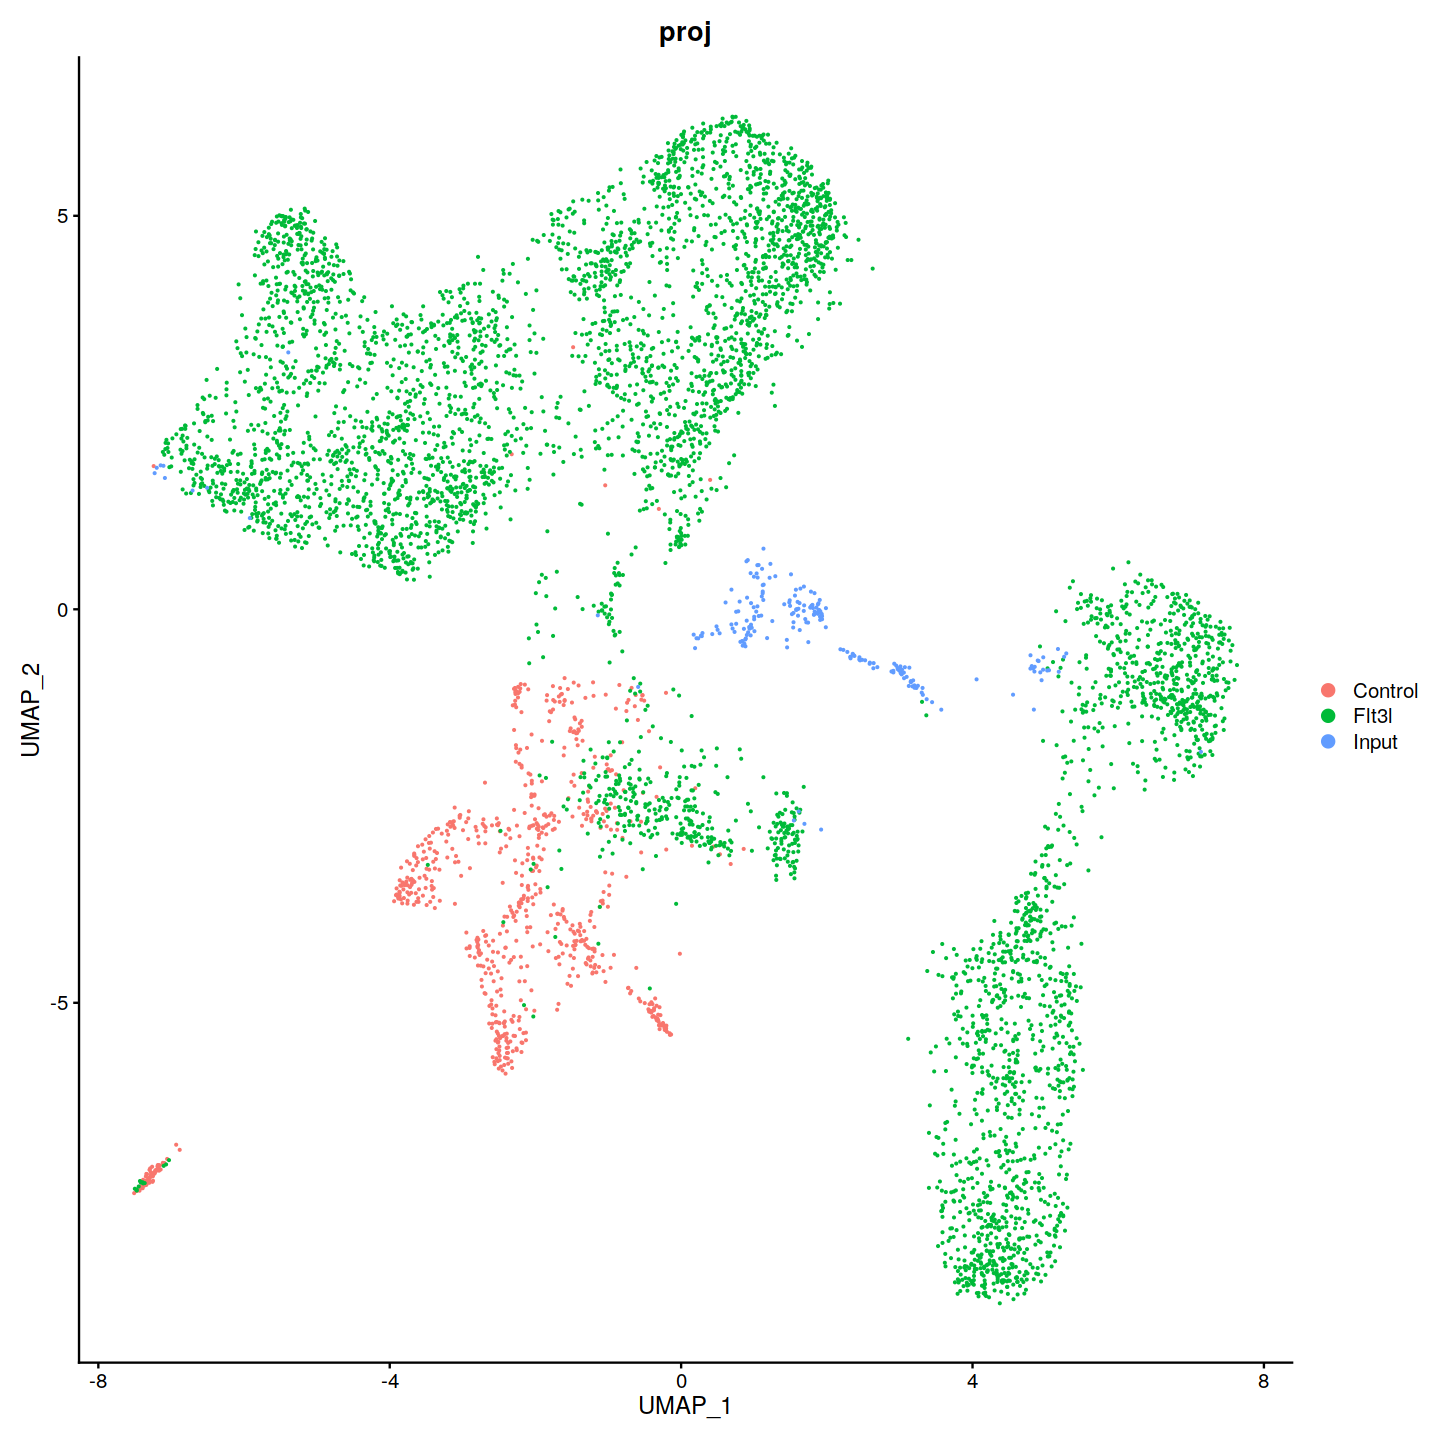

In [14]:
# Binarize and run LSI
combined <- BinarizeCounts(combined)
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = lsi_start_comp:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

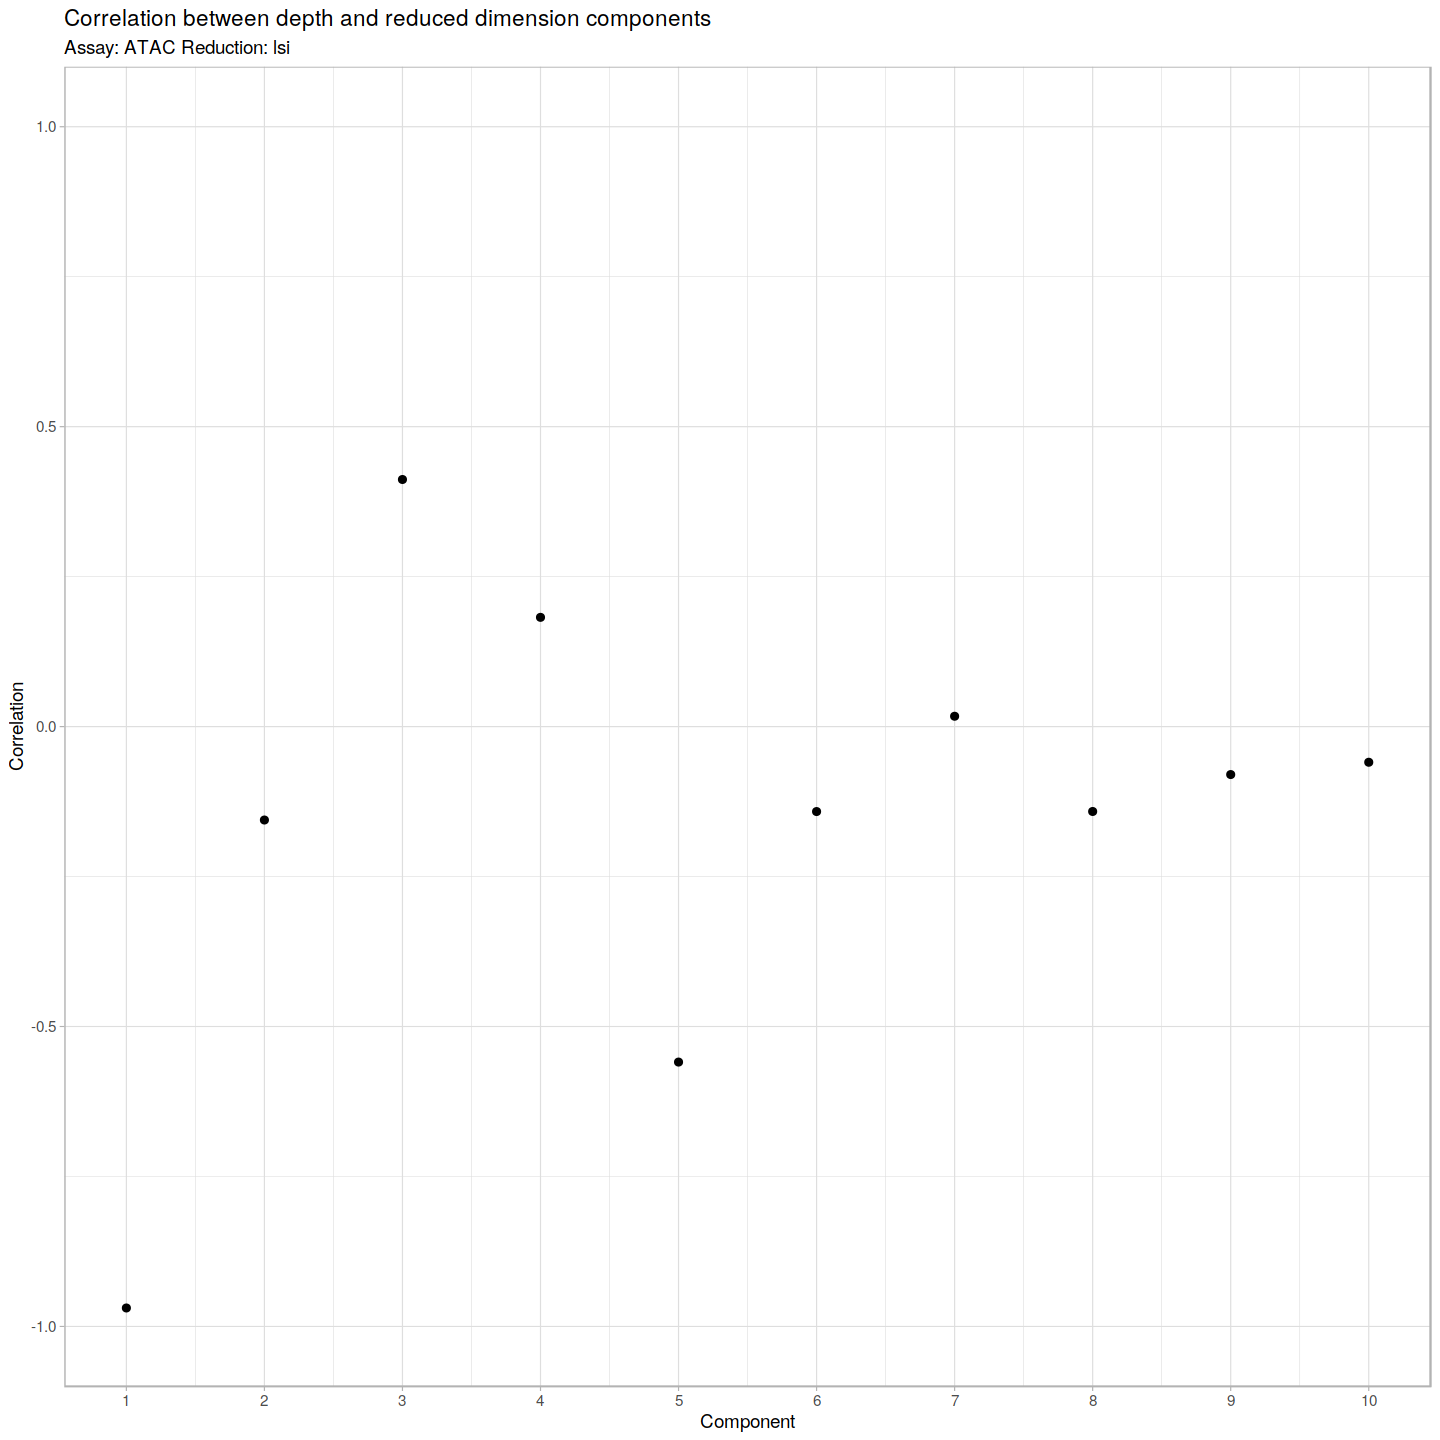

In [15]:
pDepthCorr <- DepthCor(combined)
pDepthCorr

In [16]:
saveRDS(combined, file.path(outdir, paste0("allSamples.merged.rds")))

## Integrate datasets
### Uses https://satijalab.org/signac/articles/integrate_atac.html

In [17]:
p1 <- DimPlot(combined, group.by = "proj")

## First break them up again by subsetting, then integrating

In [18]:
# ext <- subset(x = combined, subset = orig.ident == samples[1])
# curr <- subset(x = combined, subset = orig.ident == samples[2])

allSE <- lapply(sample_names,  function(x) subset(combined, subset = orig.ident == x))
allSE

[[1]]
An object of class Seurat 
189527 features across 743 samples within 1 assay 
Active assay: ATAC (189527 features, 158057 variable features)
 2 dimensional reductions calculated: lsi, umap

[[2]]
An object of class Seurat 
189527 features across 5312 samples within 1 assay 
Active assay: ATAC (189527 features, 158057 variable features)
 2 dimensional reductions calculated: lsi, umap

[[3]]
An object of class Seurat 
189527 features across 222 samples within 1 assay 
Active assay: ATAC (189527 features, 158057 variable features)
 2 dimensional reductions calculated: lsi, umap


In [19]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = allSE, #c(ext,curr),
  anchor.features = allSE[[1]], #rownames(ext),
  reduction = "rlsi",
  dims = lsi_start_comp:30
)

# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = combined[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)



Computing within dataset neighborhoods

Finding all pairwise anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 458 anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 125 anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 797 anchors

Merging dataset 3 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 into 2 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [20]:
# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")

02:52:42 UMAP embedding parameters a = 0.9922 b = 1.112

02:52:42 Read 6277 rows and found 29 numeric columns

02:52:42 Using Annoy for neighbor search, n_neighbors = 30

02:52:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

02:52:43 Writing NN index file to temp file /tmp/RtmpOqygQt/file448d3aaa0e

02:52:43 Searching Annoy index using 24 threads, search_k = 3000

02:52:43 Annoy recall = 100%

02:52:45 Commencing smooth kNN distance calibration using 24 threads

02:52:48 Initializing from normalized Laplacian + noise

02:52:49 Commencing optimization for 500 epochs, with 263316 positive edges

02:53:00 Optimization finished



Saving 6.67 x 6.67 in image



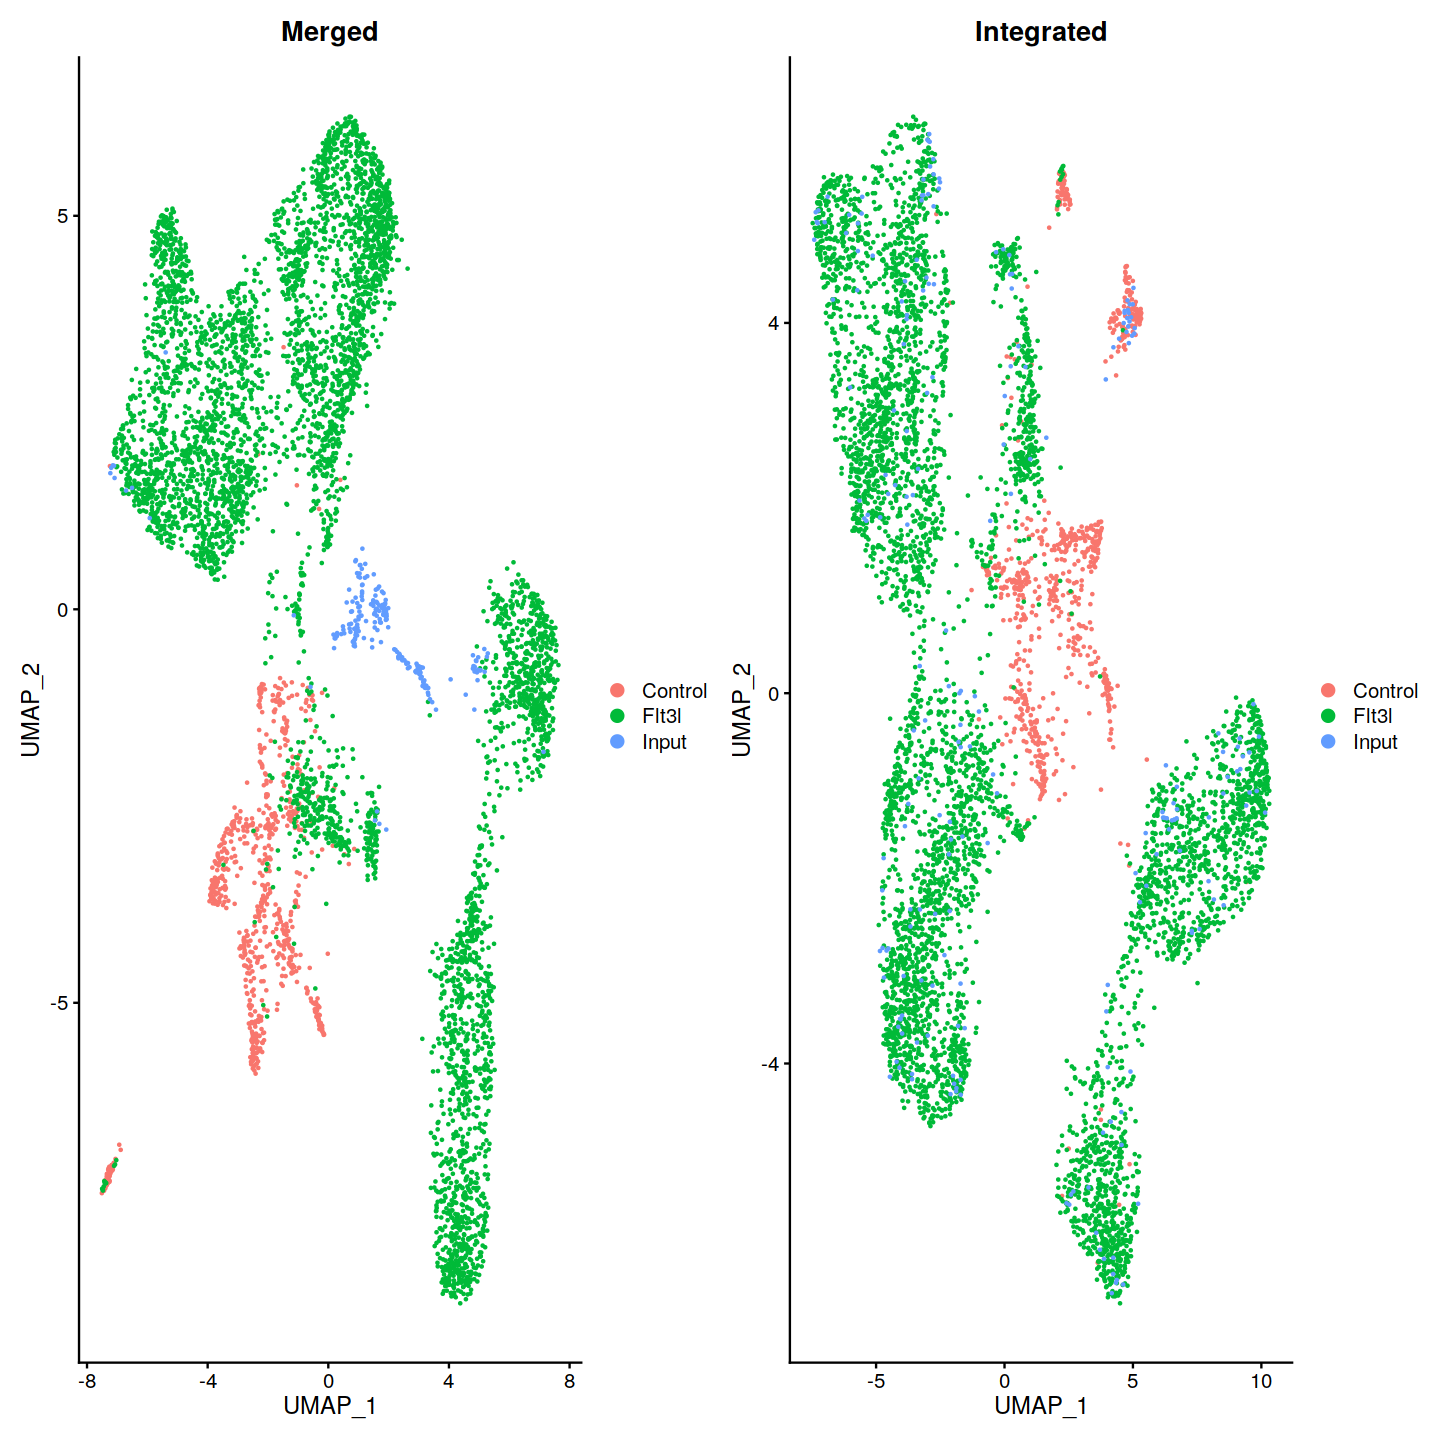

In [21]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()

(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"))

Saving 6.67 x 6.67 in image



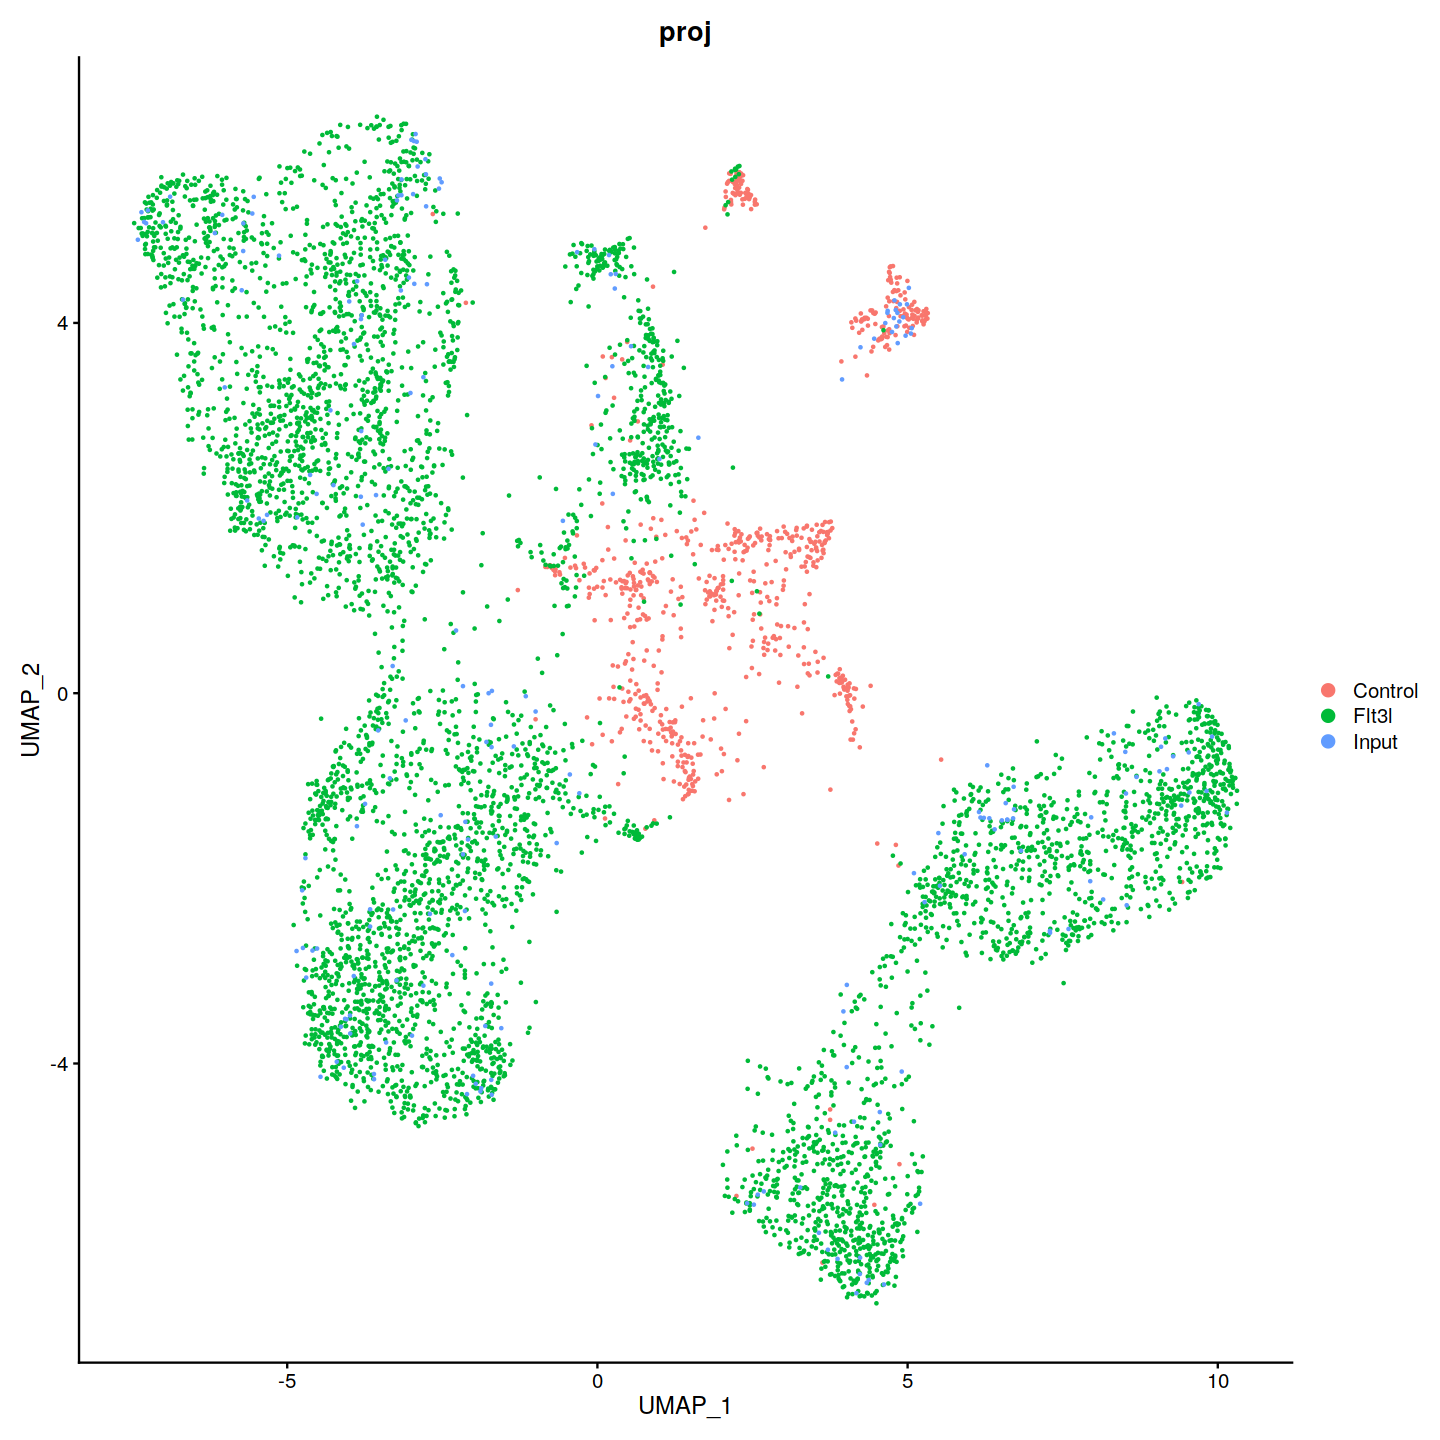

In [22]:
p2
ggsave(file.path(outdir,"integrated.batch.png"), dpi=300)

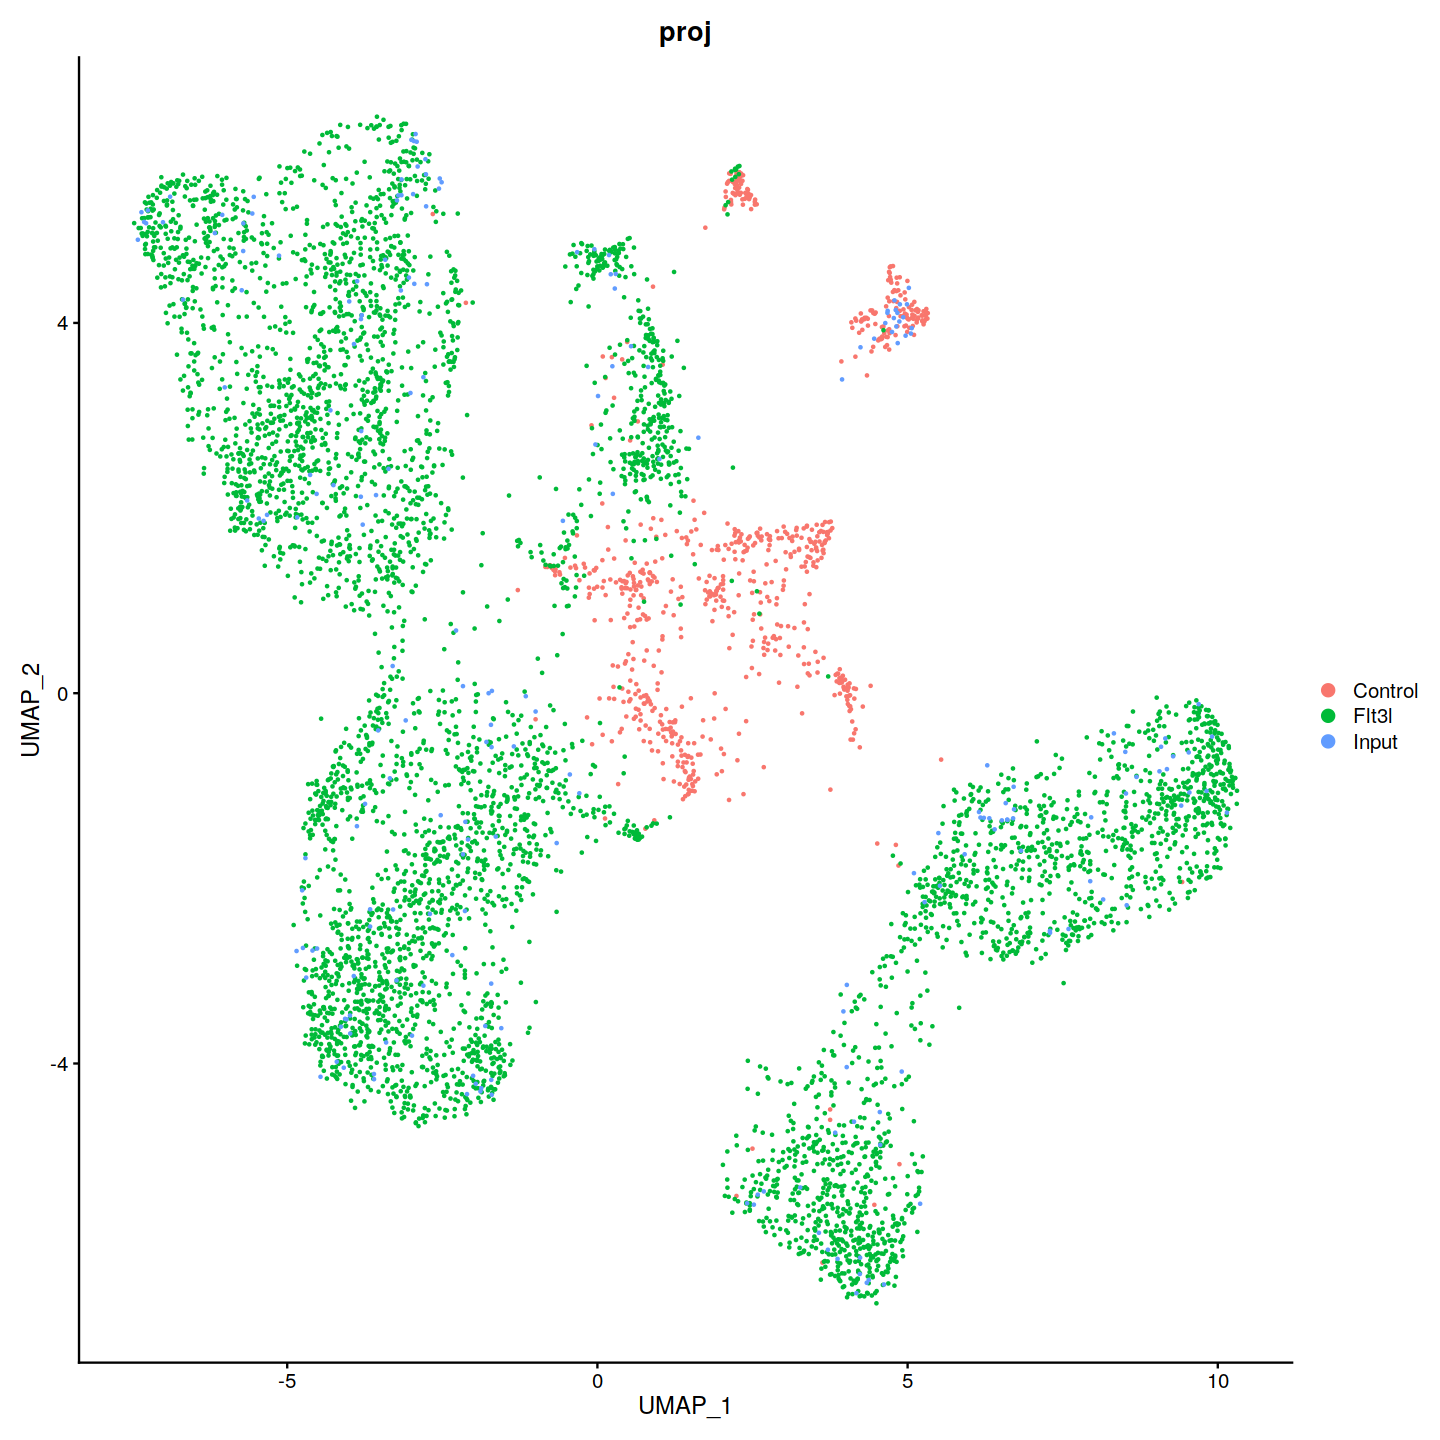

In [23]:
p2

Saving 6.67 x 6.67 in image



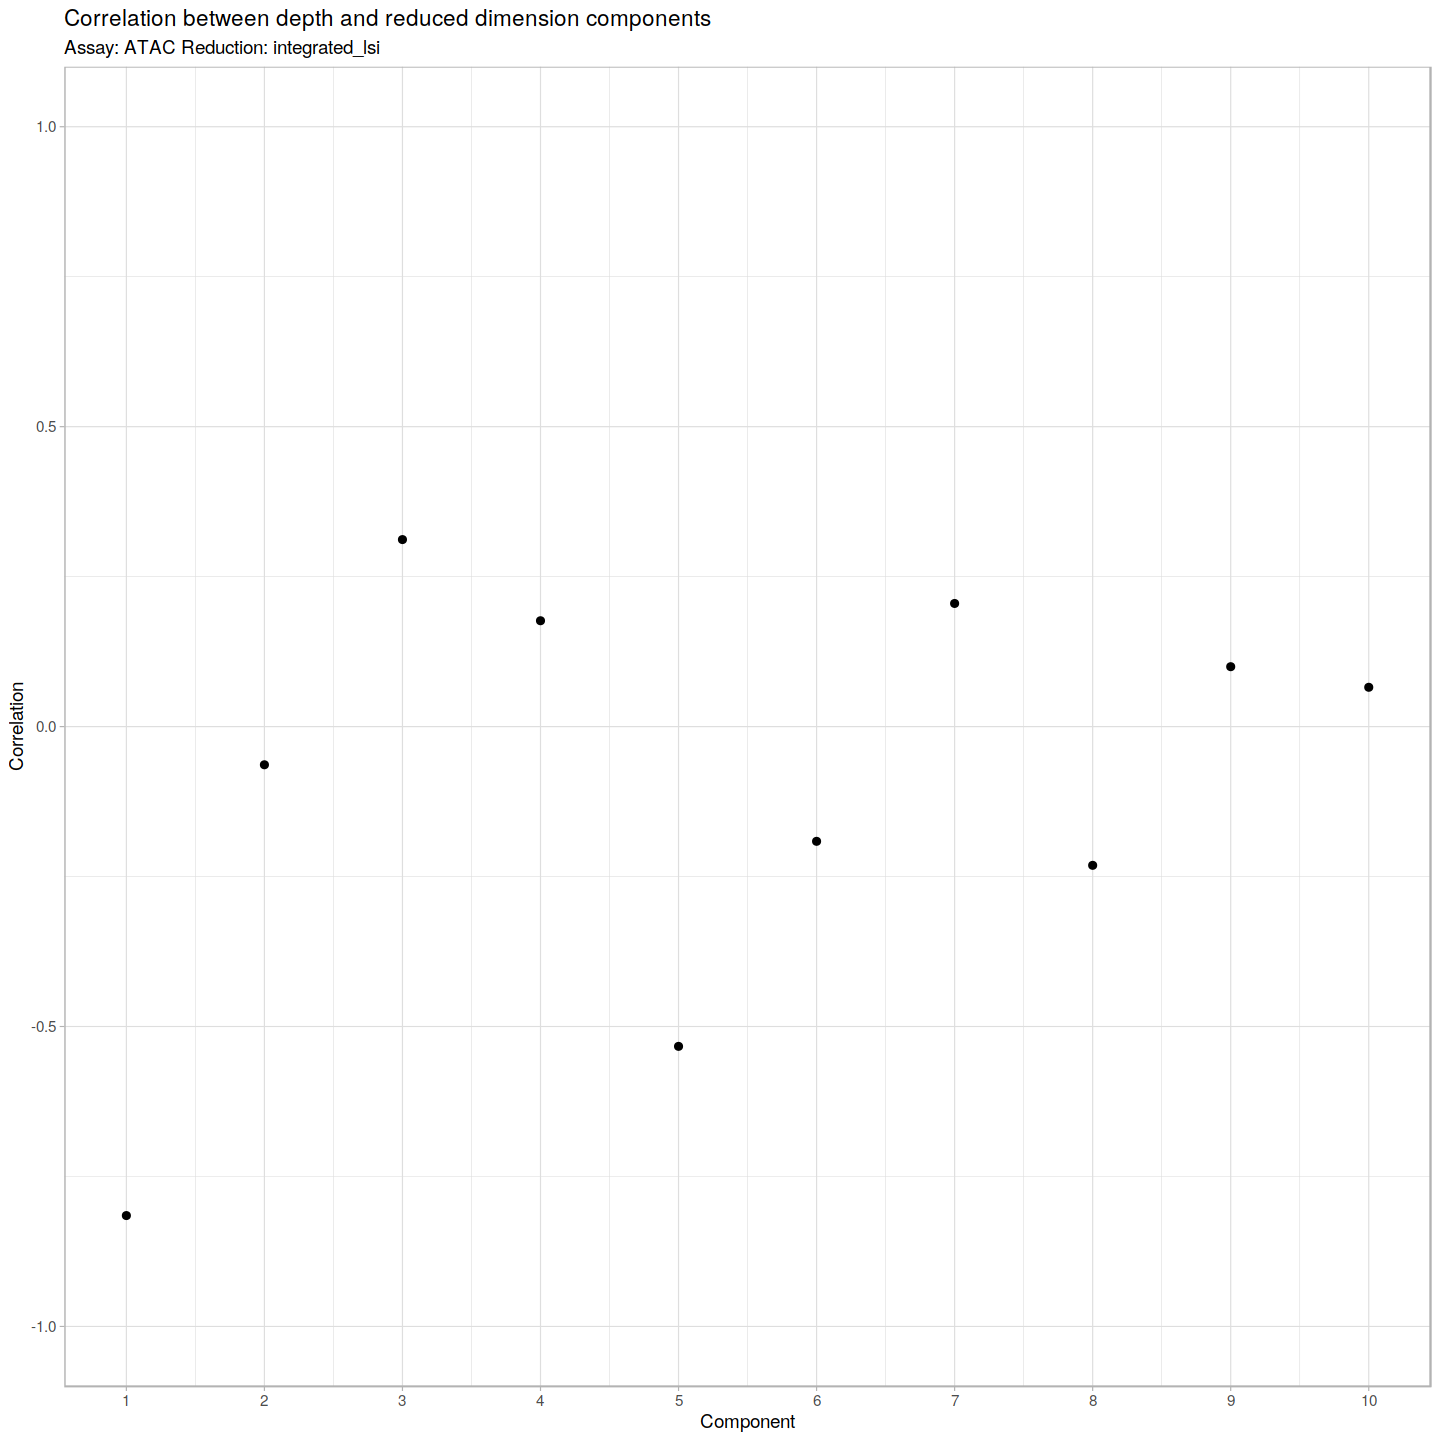

In [24]:
pDepthCorr <- DepthCor(integrated, reduction='integrated_lsi')
ggsave(file.path(outdir,"integrated.depthCor.png"), plot=pDepthCorr, dpi=300)

pDepthCorr

## Plot new cluster results

In [25]:
#integrated <- RunUMAP(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)


Computing nearest neighbor graph

Computing SNN

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."


Saving 6.67 x 6.67 in image



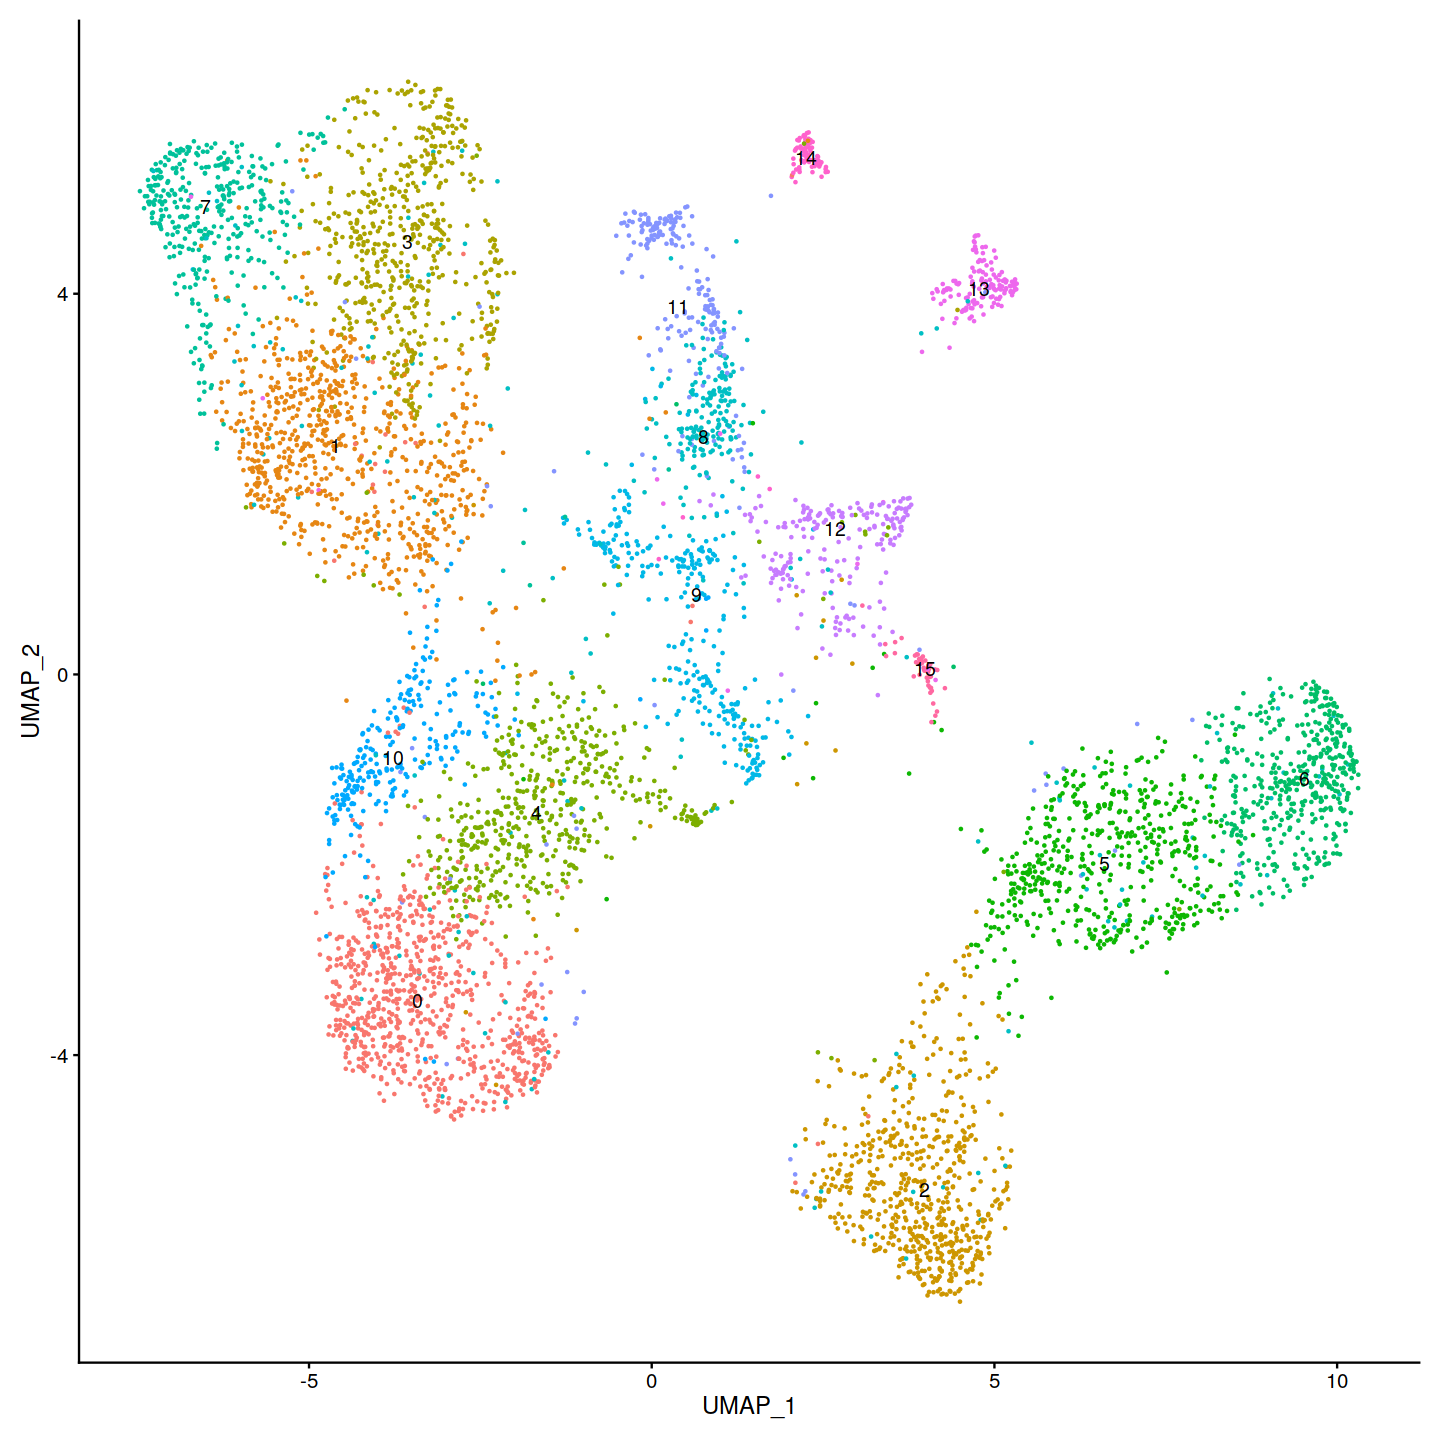

In [26]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
pclust

In [27]:
## ATAC DE peaks

# # change back to working with peaks instead of gene activities
# DefaultAssay(integrated) <- 'ATAC'

# da_peaks <- FindMarkers(
#   object = integrated,
#   ident.1 = 9, #"CD4 Naive",
#   min.pct = 0.05,
#   test.use = 'LR',
#   #latent.vars = 'peak_region_fragments'
# )


# plot1 <- VlnPlot(
#   object = integrated,
#   features = rownames(da_peaks)[1],
#   pt.size = 0.1,
#   idents = c(1,9)
# )
# plot2 <- FeaturePlot(
#   object = integrated,
#   features = rownames(da_peaks)[1],
#   pt.size = 0.1
# )

# plot1 | plot2


## Get gene activity results and run DE results for RNA

In [28]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(integrated) <- annotations


gene.activities <- GeneActivity(integrated)


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [29]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


In [30]:
DefaultAssay(integrated) <- 'RNA'

In [31]:
saveRDS(integrated, file.path(outdir, paste0("allSamples.integrated.rds")))

## Save all figures

In [32]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/isshamie/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.22.1             dplyr_1.0.7              
 [3] metap_1.5                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.16.4  

In [ ]:
print